#Face recognition with Siamese Network
this notebook is implemented base on this [repo](https://github.com/dedhiaparth98/face-recognition) and his [blog](https://towardsdatascience.com/building-face-recognition-model-under-30-minutes-2d1b0ef72fda)





In [1]:
import os
import cv2
import dlib
import pickle
import random
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from datetime import datetime
from imutils import face_utils

ModuleNotFoundError: No module named 'tqdm'

In [ ]:
'''
The following code cell is taken from the source code of keras_vggface.'
I tried using the preprocess_input function provided by tf.keras but they provide different results.
To my knowledge, it seems that the mean values which are subtracted in each image are different.
'''
K = tf.keras.backend

def preprocess_input(x, data_format=None, version=1):
    x_temp = np.copy(x)
    if data_format is None:
        data_format = K.image_data_format()
    assert data_format in {'channels_last', 'channels_first'}

    if version == 1:
        if data_format == 'channels_first':
            x_temp = x_temp[:, ::-1, ...]
            x_temp[:, 0, :, :] -= 93.5940
            x_temp[:, 1, :, :] -= 104.7624
            x_temp[:, 2, :, :] -= 129.1863
        else:
            x_temp = x_temp[..., ::-1]
            x_temp[..., 0] -= 93.5940
            x_temp[..., 1] -= 104.7624
            x_temp[..., 2] -= 129.1863

    elif version == 2:
        if data_format == 'channels_first':
            x_temp = x_temp[:, ::-1, ...]
            x_temp[:, 0, :, :] -= 91.4953
            x_temp[:, 1, :, :] -= 103.8827
            x_temp[:, 2, :, :] -= 131.0912
        else:
            x_temp = x_temp[..., ::-1]
            x_temp[..., 0] -= 91.4953
            x_temp[..., 1] -= 103.8827
            x_temp[..., 2] -= 131.0912
    else:
        raise NotImplementedError

    return x_temp

#VGG16 architecture

In [ ]:
vggface = tf.keras.models.Sequential()
vggface.add(tf.keras.layers.Convolution2D(64, (3, 3), activation='relu', padding="SAME", input_shape=(224,224, 3)))
vggface.add(tf.keras.layers.Convolution2D(64, (3, 3), activation='relu', padding="SAME"))
vggface.add(tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)))
 
vggface.add(tf.keras.layers.Convolution2D(128, (3, 3), activation='relu', padding="SAME"))
vggface.add(tf.keras.layers.Convolution2D(128, (3, 3), activation='relu', padding="SAME"))
vggface.add(tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)))
 
vggface.add(tf.keras.layers.Convolution2D(256, (3, 3), activation='relu', padding="SAME"))
vggface.add(tf.keras.layers.Convolution2D(256, (3, 3), activation='relu', padding="SAME"))
vggface.add(tf.keras.layers.Convolution2D(256, (3, 3), activation='relu', padding="SAME"))
vggface.add(tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)))
 
vggface.add(tf.keras.layers.Convolution2D(512, (3, 3), activation='relu', padding="SAME"))
vggface.add(tf.keras.layers.Convolution2D(512, (3, 3), activation='relu', padding="SAME"))
vggface.add(tf.keras.layers.Convolution2D(512, (3, 3), activation='relu', padding="SAME"))
vggface.add(tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)))
 
vggface.add(tf.keras.layers.Convolution2D(512, (3, 3), activation='relu', padding="SAME"))
vggface.add(tf.keras.layers.Convolution2D(512, (3, 3), activation='relu', padding="SAME"))
vggface.add(tf.keras.layers.Convolution2D(512, (3, 3), activation='relu', padding="SAME"))
vggface.add(tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)))

vggface.add(tf.keras.layers.Flatten())

vggface.add(tf.keras.layers.Dense(4096, activation='relu'))
vggface.add(tf.keras.layers.Dropout(0.5))
vggface.add(tf.keras.layers.Dense(4096, activation='relu'))
vggface.add(tf.keras.layers.Dropout(0.5))
vggface.add(tf.keras.layers.Dense(2622, activation='softmax'))

vggface.pop()
vggface.add(tf.keras.layers.Dense(128, use_bias=False))

for layer in vggface.layers[:-2]:
    layer.trainable = False

#Siamese Network

In [ ]:
class SiameseNetwork(tf.keras.Model):
    def __init__(self, vgg_face):
        super(SiameseNetwork, self).__init__()
        self.vgg_face = vgg_face
        
    @tf.function
    def call(self, inputs):
        image_1, image_2, image_3 =  inputs
        with tf.name_scope("Anchor") as scope:
            feature_1 = self.vgg_face(image_1)
            feature_1 = tf.math.l2_normalize(feature_1, axis=-1)
        with tf.name_scope("Positive") as scope:
            feature_2 = self.vgg_face(image_2)
            feature_2 = tf.math.l2_normalize(feature_2, axis=-1)
        with tf.name_scope("Negative") as scope:
            feature_3 = self.vgg_face(image_3)
            feature_3 = tf.math.l2_normalize(feature_3, axis=-1)
        return [feature_1, feature_2, feature_3]
    
    @tf.function
    def get_features(self, inputs):
        return tf.math.l2_normalize(self.vgg_face(inputs), axis=-1)

In [ ]:
model = SiameseNetwork(vggface)

In [ ]:
#sample usage
# _ = model([tf.zeros((32,224,224,3)), tf.zeros((32,224,224,3)), tf.zeros((32,224,224,3))])
# _ = model.get_features(tf.zeros((32,224,224,3)))

#load pretrained weight

In [ ]:
!gdown --id 1MegWliwXx2J-xHYX6iETl7hXUtLRk2sC

Downloading...
From: https://drive.google.com/uc?id=1MegWliwXx2J-xHYX6iETl7hXUtLRk2sC
To: /content/logs.7z
505MB [00:05, 95.9MB/s]


In [ ]:
!7z e /content/logs.7z


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content                  1 file, 504813449 bytes (482 MiB)

Extracting archive: /content/logs.7z
--
Path = /content/logs.7z
Type = 7z
Physical Size = 504813449
Headers Size = 459
Method = LZMA:23
Solid = +
Blocks = 1

      0% - logs/model/siamese-1.inde                                  1% 2 - logs/model/siamese-1.data-00000-of-0000                                                  2% 2 - logs/model/siamese-1.data-00000-of-0000                                                  3% 2 - logs/model/siamese-1.data-00000-of-0000                                                  4% 2 - logs/model/siamese-1.data-00000-of-0000                                                  5% 2 - logs/model/siamese-1.data-00000-of-0000                                        

In [ ]:
#call checkpoint from siamese-1.index
checkpoint_path = 'siamese-1'

In [ ]:
checkpoint = tf.train.Checkpoint(model=model)
checkpoint.restore(checkpoint_path)

# Data Collection Details
The cell below should be re-run for data collection for multiple people.
For a single person, you could  collect 8-10 images tops. Entering the name of the person would add a directory to the data folder which will be the name of that person. 
If the name of the person exists it will give an error. So make sure to keep different names.

In [ ]:
if "data" not in os.listdir("."):
  os.makedirs("data")

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

def take_photo(quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 

  return img

In [ ]:
data_dir = 'data'

#[COLAB] capture sample image from webcam

In [ ]:
name = input("Enter the name of the person : ")
os.mkdir(os.path.join(data_dir, name))
count = 0

while True:
  img = take_photo()
  count += 1
  file_path = os.path.join(data_dir, name + '/' + str(count) + '.png')
  cv2.imwrite( file_path, img)
  print('Saved to {}'.format(file_path))
  # Show the image which was just taken.
  # display(Image(filename))
  if count == 1:
    break

Enter the name of the person : earth


<IPython.core.display.Javascript object>

Saved to data/earth/1.png


you can also manually upload your image in data/person_name/image_name.jpg

#[JETSON] capture sample image

In [ ]:
name = input("Enter the name of the person : ")
os.mkdir(os.path.join(data_dir, name))
cap = cv2.VideoCapture(0)
count = 0
while True:
    ret, frame = cap.read()
    cv2.imshow('Image', frame)
    
    k = cv2.waitKey(1)
    if k == ord('s'):
        cv2.imwrite(os.path.join(data_dir, name + '/' + str(count) + '.png') , frame)
        count += 1
    if k ==ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

#Extract features

In [ ]:
people = sorted(os.listdir(data_dir))
people = [f for f in people if not "." in f]
face_detector = dlib.get_frontal_face_detector()
features = []
dumpable_features = {}
print(people)

['earth', 'nish', 'pan', 'patter']


In [ ]:
!ls -la data/earth

total 328
drwxr-xr-x 3 root root   4096 May  5 18:38 .
drwxr-xr-x 7 root root   4096 May  5 18:34 ..
-rw-r--r-- 1 root root 321023 May  5 18:38 earth1.jpg
drwxr-xr-x 2 root root   4096 May  5 18:38 .ipynb_checkpoints


In [ ]:
for person in people:
    person_path = os.path.join(data_dir, person)
    print(person_path)
    images = []
    for image in [f for f in os.listdir(person_path) if ".jpg" in f]:
        image_path = os.path.join(person_path, image)
        img = cv2.imread(image_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_detector(gray, 0)
        if len(faces) == 1:
            for face in faces:
                face_bounding_box = face_utils.rect_to_bb(face)
                if all(i >= 0 for i in face_bounding_box):
                    [x, y, w, h] = face_bounding_box
                    frame = img[y:y + h, x:x + w]
                    frame = cv2.resize(frame, (224, 224))
                    frame = np.asarray(frame, dtype=np.float64)
                    images.append(frame)
    images = np.asarray(images)
    images = preprocess_input(images)
    images = tf.convert_to_tensor(images)

    #extract feature from all detected faces
    feature = model.get_features(images)

    #find mean of the face features
    feature = tf.reduce_mean(feature, axis=0)

    #result in one feature per one person's face
    features.append(feature.numpy())
    dumpable_features[person] = feature.numpy()

data/earth
data/nish
data/pan
data/patter


# Dumping Features Rather than Calculating Them every time (optional)

I have added a variable dumpable_features which could be pickled. It will save a dictionary format of {'name':'features (numpy array)'} for each person. Simply pickle using the following commands
```
with open('weigths.pkl', 'wb') as f:
    pickle.dump(dumpable_features, f) 
```
and reload them using
```
with open('weigths.pkl', 'rb') as f:
    dumpable_features_reloaded = pickle.load(f)
    
people = []
features = []
for key, value in dumpable_features_reloaded.items():
    people.append(key)
    features.append(value)
```
During my testing I tested on 8-10 people so regenerating features wasn't that much slow. 

In [ ]:
features = np.asarray(features)
features

array([[ 0.0567195 ,  0.08345036,  0.03369347, -0.13253541, -0.0432095 ,
        -0.02547304, -0.04640588,  0.06776209, -0.02877431, -0.15284474,
        -0.16592038,  0.0352516 , -0.06891453,  0.09555168, -0.02345579,
        -0.16765583, -0.12888013, -0.06993514, -0.08245874,  0.14137064,
         0.16835539,  0.1525083 , -0.10469921, -0.09863416, -0.14986527,
         0.03985871, -0.05961272,  0.05330298, -0.02509318, -0.04644464,
         0.00912988,  0.0603345 , -0.00793574, -0.07763238,  0.00872158,
        -0.05470614, -0.06641261, -0.0745467 , -0.03871396,  0.10150485,
         0.2650753 , -0.11542057,  0.12715982,  0.10519066, -0.03087526,
         0.09327601,  0.08189131, -0.05685785,  0.00878078, -0.16513836,
         0.05684333, -0.0139434 ,  0.12865031, -0.1366035 , -0.03444303,
        -0.07610612,  0.16992494,  0.0329723 , -0.0571962 , -0.01627617,
        -0.04999221,  0.02339978,  0.03607419,  0.03711249, -0.0835311 ,
        -0.09600089,  0.02792348, -0.11950704, -0.0

In [ ]:
print(people)

['earth', 'nish', 'pan', 'patter']


#[COLAB] Inference

In [ ]:
input_path = "earth3.jpg"

[1.1588156 1.2434638 1.1940454 1.1330048]
detected face of unknown


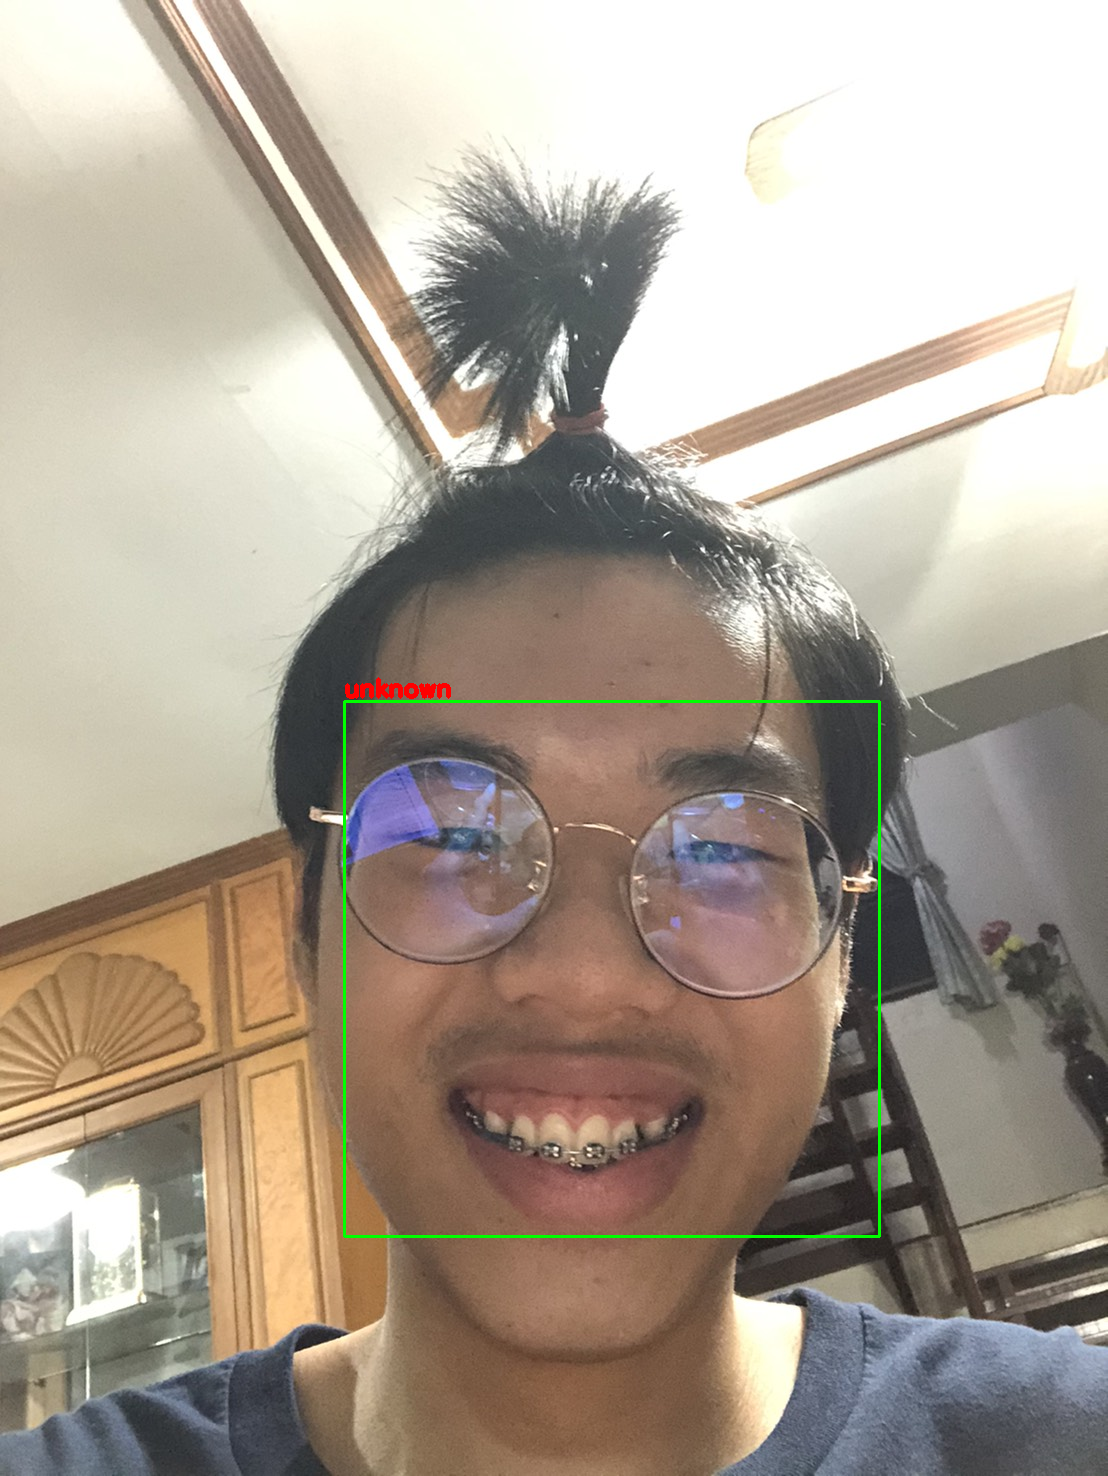

In [ ]:
from google.colab.patches import cv2_imshow

name = 'unknown'
img = cv2.imread(input_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

faces = face_detector(gray, 0)
for face in faces:
    face_bounding_box = face_utils.rect_to_bb(face)

    #check all x, y, w, h to be more than zero
    if all(i >= 0 for i in face_bounding_box):
        [x, y, w, h] = face_bounding_box
        frame = img[y:y + h, x:x + w]
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        frame = cv2.resize(frame, (224, 224))
        frame = np.asarray(frame, dtype=np.float64)
        frame = np.expand_dims(frame, axis=0)
        frame = preprocess_input(frame)
        feature = model.get_features(frame)
        
        #subtract the features(list) by feature one-by-one then calculate the norm
        dist = tf.norm(features - feature, axis=1)
        name = 'unknown'

        #find the index of lowest distance
        loc = tf.argmin(dist)
        if dist[loc] < 0.8:
            name = people[loc]
        else:
            print(dist.numpy())
            pass
                
        font_face = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img, name, (x, y-5), font_face, 0.8, (0,0,255), 3)
        print(f"detected face of {name}")

cv2_imshow(img)


#[JETSON] Inference

In [ ]:
cap = cv2.VideoCapture(0)
count = 0
name = 'not identified'
while True:
    ret, img = cap.read()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    faces = face_detector(gray, 0)
    for face in faces:
        face_bounding_box = face_utils.rect_to_bb(face)
        if all(i >= 0 for i in face_bounding_box):
            [x, y, w, h] = face_bounding_box
            frame = img[y:y + h, x:x + w]
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
            frame = cv2.resize(frame, (224, 224))
            frame = np.asarray(frame, dtype=np.float64)
            frame = np.expand_dims(frame, axis=0)
            frame = preprocess_input(frame)
            feature = model.get_features(frame)
                
            dist = tf.norm(features - feature, axis=1)
            name = 'not identified'
            loc = tf.argmin(dist)
            if dist[loc] < 0.8:
                name = people[loc]
            else:
                # print(dist.numpy())
                pass
                    
            font_face = cv2.FONT_HERSHEY_SIMPLEX
            cv2.putText(img, name, (x, y-5), font_face, 0.8, (0,0,255), 3)
    cv2.imshow('Image', img)
    k = cv2.waitKey(1)
    if k ==ord('q'):
        break
cap.release()
cv2.destroyAllWindows()